# Search Methods

In this notebook, we will showcase how to use the Efficient Active Search (EAS) algorithm to find better solutions to existing problems!

This notebook is based heavily on the fourth tutorial from rl4co (including most text, comments, etc.)

In [ ]:
!pip install rl4co

In [ ]:
import torch

from rl4co.envs import TSPEnv, CVRPEnv
from rl4co.models.zoo.am import AttentionModel
from rl4co.utils.trainer import RL4COTrainer
from rl4co.models.nn.utils import get_log_likelihood
from rl4co.models.zoo import EAS, EASLay, EASEmb, ActiveSearch

import logging

In [ ]:
# Load from checkpoint; alternatively, simply instantiate a new model
checkpoint_path = "last.ckpt" # model trained for one epoch only just for showing the examples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load checkpoint
# checkpoint = torch.load(checkpoint_path)

model = AttentionModel.load_from_checkpoint(checkpoint_path, load_baseline=False)
policy = model.policy.to(device)

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.
  rank_zero_warn(
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/core/saving.py:165: UserWarning: Found keys that are not in the model state dict but in the checkpoint: ['baseline.baseline.model.encoder.init_embedding.init_embed.weight', 'baseline.baseline.model.encoder.init_embedding.init_embed.bias', 'baseline.baseline.model.encoder.net.layers.0.0.module.Wqkv.weight', 'baseline.baseline.model.encoder.net.layers.0.0.modu

In [ ]:
env = TSPEnv(num_loc=20)

td = env.reset(batch_size=3).to(device)

out = policy(td, return_actions=True)

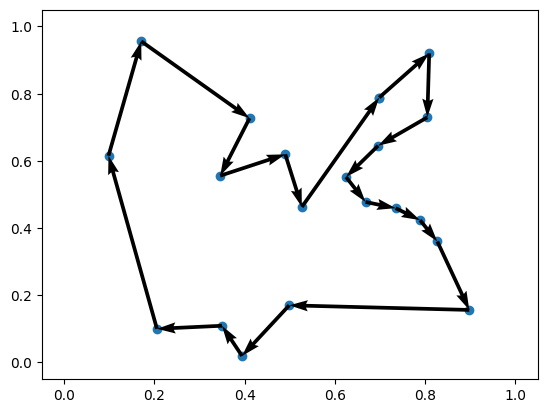

In [ ]:
env.render(td.cpu(), out["actions"].cpu())

## EAS

We perform few iterations of EASLay for demonstration

In [ ]:
logging.basicConfig(level=logging.DEBUG)

env.num_loc = 20

dataset = env.dataset(batch_size=[2])
# eas_model = EASEmb(env, policy, dataset, batch_size=2, max_iters=20, save_path="eas_sols.pt") # alternative
eas_model = EASLay(env, policy, dataset, batch_size=2, max_iters=20, save_path="eas_sols.pt")

eas_model.setup()

Objective function: 3.77


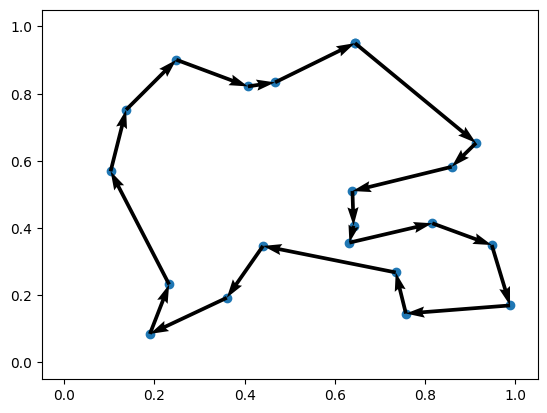

In [ ]:
# Plot initial solution
td_dataset = next(iter(eas_model.train_dataloader()))
td_dataset = env.reset(td_dataset).to(device)
out = policy(td_dataset, return_actions=True)

print(f"Objective function: {-out['reward'][0]:.2f}")
env.render(td_dataset.cpu(), out["actions"].cpu())

## Perform search


In [ ]:
from rl4co.utils.trainer import RL4COTrainer

trainer = RL4COTrainer(
    max_epochs=1,
    gradient_clip_val=None,
)

trainer.fit(eas_model)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name   | Type                 | Params
------------------------------------------------
0 | env    | TSPEnv               | 0     
1 | policy | AttentionModelPolicy | 710 K 
------------------------------------------------
710 K     Trainable params
0         Non-trainable params
710 K     Total params
2.841     Total estimated model params size (MB)
INFO:lightning.pytorch.callbacks.model_summary:
  | Name   | Type                 | Params
---

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/rl4co/models/zoo/eas/nn.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.W1)
/usr/local/lib/python3.10/dist-packages/rl4co/models/zoo/eas/nn.py:23: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(self.b1)


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1` reached.


## Load actions


Objective function: 3.00


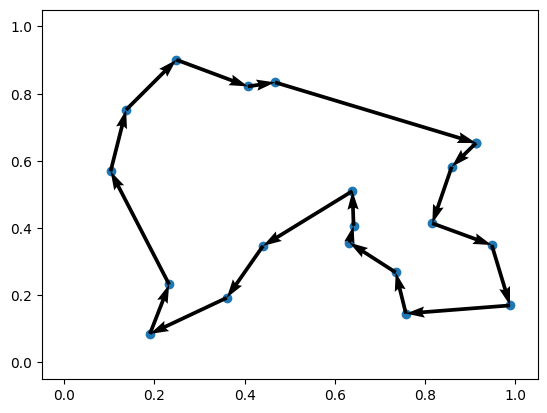

In [ ]:
# Load
actions = torch.load("eas_sols.pt")["solutions"][0].cpu()
actions = actions[:torch.count_nonzero(actions, dim=-1)] # remove trailing zeros
state = td_dataset.cpu()[0]

# compute cost, since this isn't saved
cost = 0
for ii,jj in zip(actions[:-1], actions[1:]):
  li = td_dataset['locs'][0][ii]
  lj = td_dataset['locs'][0][jj]
  cost += torch.sqrt(torch.sum(torch.square(lj - li)))

print(f"Objective function: {cost:.2f}")
env.render(state, actions)

Even with few iterations, the search method can clearly find better solutions than the initial ones!